In [8]:
import numpy as np;
import pandas as pd;
from pandas.plotting import autocorrelation_plot as auto_corr;
import matplotlib as mpl;
import seaborn as sns;
import math;
from datetime import datetime;
from datetime import timedelta;
import itertools;
import statsmodels.api as sm;
import statsmodels.tsa.api as smt;
import statsmodels.formula.api as smf;
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.model_selection import cross_val_score;
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score,balanced_accuracy_score;
from sklearn.pipeline import Pipeline,make_pipeline;
from sklearn.ensemble import RandomForestRegressor;
from sklearn import metrics;
from sklearn.linear_model import LinearRegression;
from sklearn import preprocessing;
from statsmodels.tsa.holtwinters import ExponentialSmoothing;
from statsmodels.tsa.stattools import adfuller,acf,pacf;
from statsmodels.tsa.arima_model import ARIMA;
from pmdarima.utils import decomposed_plot;
from pmdarima.arima import decompose
from pmdarima import auto_arima;

In [2]:
import torch;
torch.rand(3,5)

tensor([[0.6743, 0.0069, 0.0609, 0.9991, 0.8491],
        [0.0227, 0.2543, 0.9973, 0.1375, 0.3003],
        [0.2705, 0.8025, 0.7488, 0.9998, 0.8444]])

In [9]:
pd.options.display.max_columns=100

to display the columns

In [10]:
df_store=pd.read_csv("./stores.csv")
df_train=pd.read_csv("./train.csv")
df_features=pd.read_csv("./features.csv")
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [12]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Now we merge the three dataframes

In [13]:
df=df_train.merge(df_features,on=["Store","Date"],how="inner").merge(df_store,on="Store",how="inner")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


now you can see we have sucessfully merged the 3 dataframe into a singe dataframe.

In [14]:
df.drop(["IsHoliday_y"],axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':"IsHoliday"},inplace=True)

We removed the publicated column

In [15]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [16]:
df.shape

(421570, 16)

In [17]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [18]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [19]:
df["Store"].unique(),df["Store"].nunique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64),
 45)

In [20]:
df["Dept"].nunique()

81

So there are 45 stores and 81 departments, now we look at average weekly sales for each store and each department to check for any misleading values.

In [21]:
store_dept_table=pd.pivot_table(df,index='Store',columns='Dept',values='Weekly_Sales',aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Since there are some negative values and missing columns in the chart we change these values 

In [22]:
df.loc[df["Weekly_Sales"]<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


We gotta delete these values

In [23]:
df=df.loc[df['Weekly_Sales']>0]
df.shape

(420212, 16)

In [24]:
df["Date"].head(5).append(df["Date"].tail(5))

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

Our date is from 5th of feb 2010 to 26th of october 2012

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

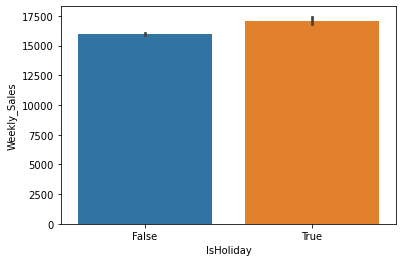

In [25]:
sns.barplot(x='IsHoliday',y='Weekly_Sales',data=df)

In [26]:
df_holiday=df.loc[df["IsHoliday"]==True]
df_holiday["Date"].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [27]:
df_holiday["Date"].nunique()

10

In [28]:
df_not_holiday=df.loc[df["IsHoliday"]==False]
df_not_holiday["Date"].nunique()

133

There are 10 weeks of holiday and 133 weeks of non holiday in our dataset. It is seen that weekly sales are higher during the holiday season.|

In [29]:
df["Type"].unique()

array(['A', 'B', 'C'], dtype=object)

There are three different types of stores we need to see their effect on the holidays.

In [30]:
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [31]:
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [32]:
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [33]:
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

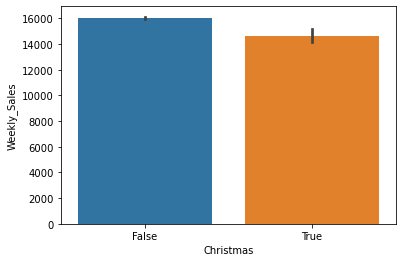

In [34]:
sns.barplot(x="Christmas",y="Weekly_Sales",data=df)

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

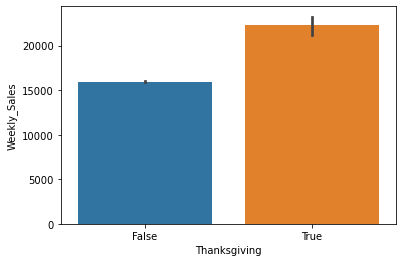

In [35]:
sns.barplot(x="Thanksgiving",y="Weekly_Sales",data=df)

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

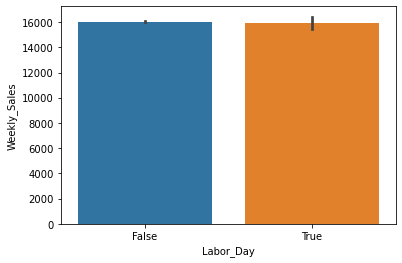

In [36]:
sns.barplot(x="Labor_Day",y="Weekly_Sales",data=df)

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

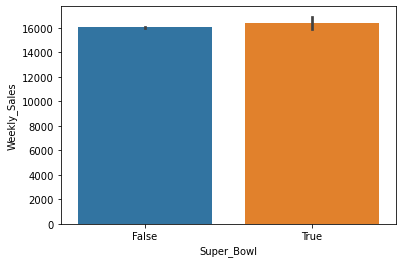

In [37]:
sns.barplot(x="Super_Bowl",y="Weekly_Sales",data=df)

In [38]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [39]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [40]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [41]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

These are the average weekly sales for the stores of type A,B,C during the given holidays 

([<matplotlib.patches.Wedge at 0x202a3f88a60>,
 [Text(0.03835877191561935, 1.0993309804681781, 'Type A'),
  Text(-0.4821600071157257, -0.9886969846915502, 'Type B'),
  Text(1.0049093347895384, -0.44738934816650205, 'Type C')],
 [Text(0.020922966499428732, 0.5996350802553698, '48.9%'),
  Text(-0.26299636751766853, -0.5392892643772091, '37.8%'),
  Text(0.5481323644306573, -0.24403055354536474, '13.3%')])

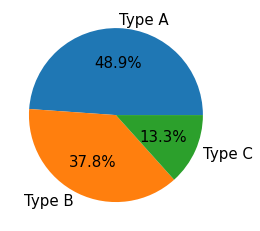

In [42]:
#now we see the % of sales of store types
my_data=[48.88,37.77,13.33]# these are the percentages
my_labels='Type A','Type B','Type C'
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%',textprops={'fontsize':15})

Most of the sales belong to Store A.

In [43]:
df.groupby(['IsHoliday'])['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

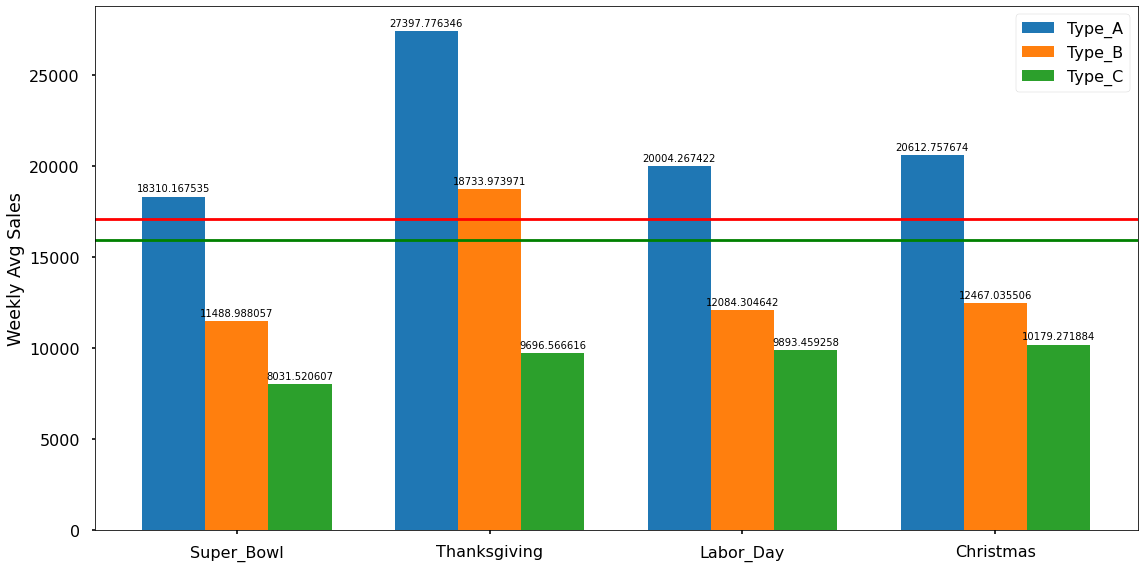

In [44]:
plt.style.use('seaborn-poster')
labels=['Super_Bowl','Thanksgiving','Labor_Day','Christmas']
A_means=[18310.167535,27397.776346,20004.267422,20612.757674]
B_means=[11488.988057,18733.973971,12084.304642,12467.035506]
C_means=[8031.520607,9696.566616,9893.459258,10179.271884]
x=np.arange(len(labels))#label locations 
width=0.25#width of the bars

fig,ax=plt.subplots(figsize=(16,8))
rects1=ax.bar(x-width,A_means,width,label="Type_A")
rects2=ax.bar(x,B_means,width,label="Type_B")
rects3=ax.bar(x+width,C_means,width,label="Type_C")

ax.set_ylabel("Weekly Avg Sales")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    # here we attach label above each bar in rects displaying the height
    for rect in rects:
        height=rect.get_height()
        ax.annotate(f"{height}",xy=(rect.get_x()+rect.get_width()/2,height),
                    xytext=(0,3),
                    textcoords='offset points',
                    ha='center',va='bottom')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') #avg of holidays
plt.axhline(y=15952.82,color='green')# avg of non-holidays
fig.tight_layout()
plt.show()        

In [45]:
df.sort_values(by="Weekly_Sales",ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


In [46]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


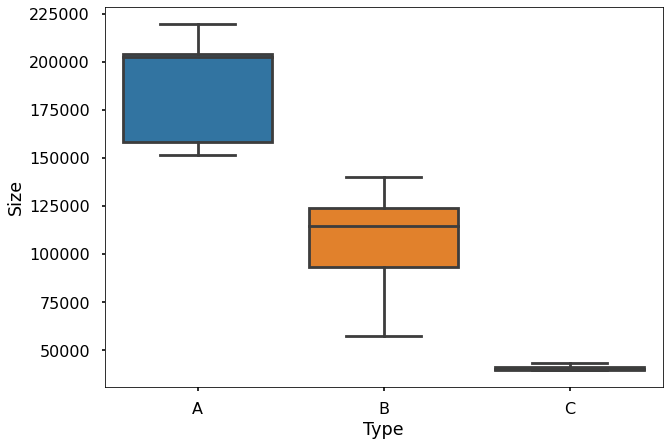

In [47]:
plt.figure(figsize=(10,7))
fig=sns.boxplot(x='Type',y='Size',data=df,showfliers=False)

In [48]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [49]:
df=df.fillna(0)

In [50]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [51]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


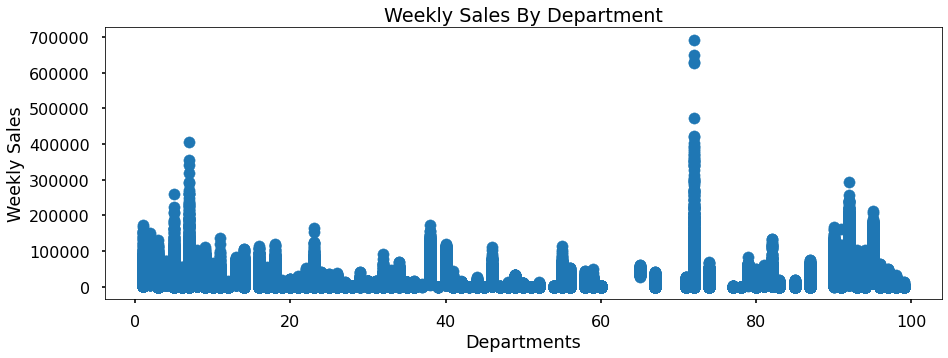

In [52]:
#deeper look into sales
x=df['Dept']
y=df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales By Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

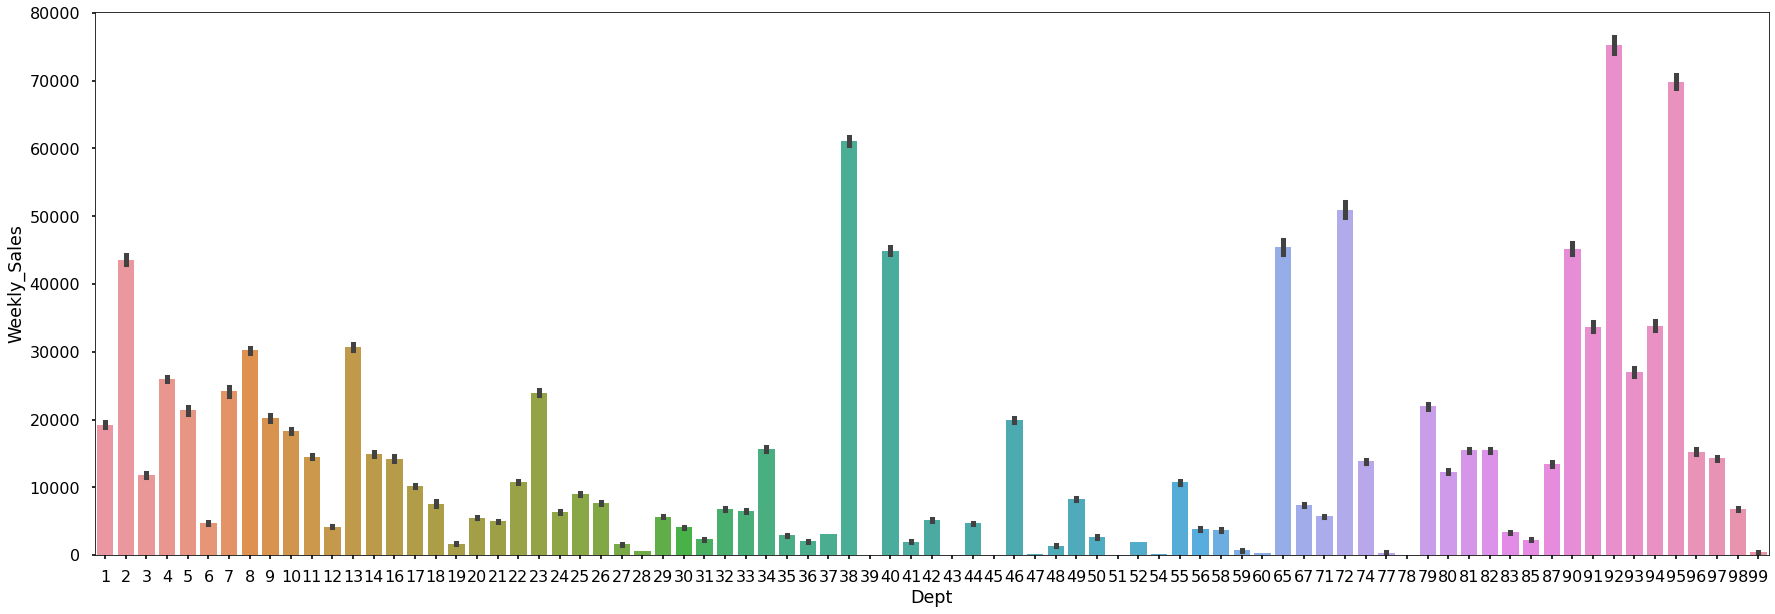

In [53]:
plt.figure(figsize=(30,10))
fig=sns.barplot(x='Dept',y='Weekly_Sales',data=df)

Seems that 92nd department has the highest no of weekly sales

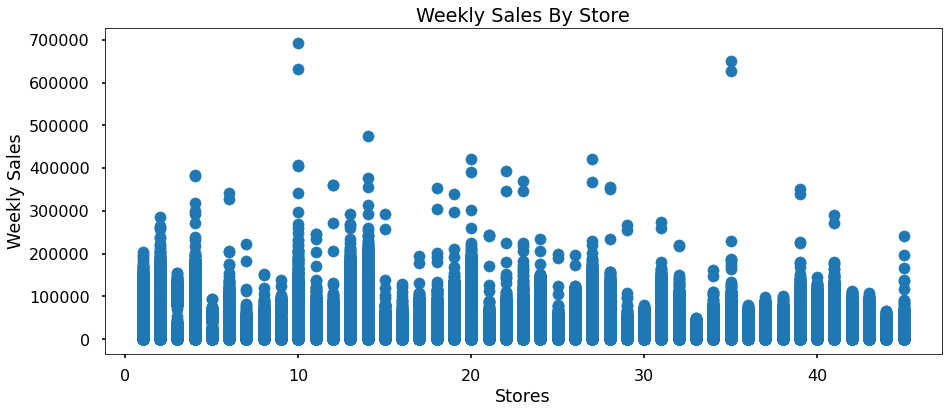

In [54]:
x=df['Store']
y=df['Weekly_Sales']
plt.figure(figsize=(15,6))
plt.title('Weekly Sales By Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

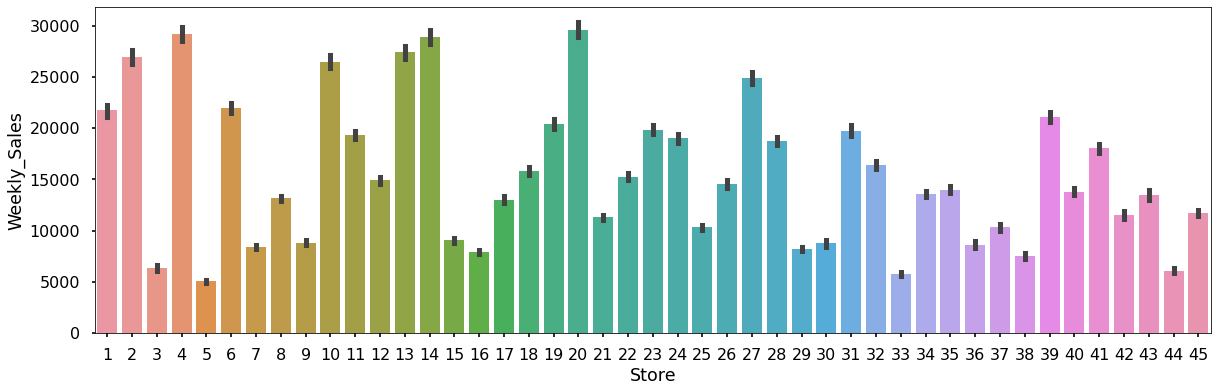

In [55]:
plt.figure(figsize=(20,6))
fig=sns.barplot(x='Store',y='Weekly_Sales',data=df)

Seems like the 20th store is doing well with weekly sales followed by 4 anad 14

In [56]:
#now we change the date to datetime by creatin new columns
df['Date']=pd.to_datetime(df["Date"])
df['Week']=df['Date'].dt.week
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year

C:\Users\rajashekar V.T\AppData\Local\Temp\ipykernel_22588\3328168115.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week']=df['Date'].dt.week


In [57]:
df.groupby(['Month'])['Weekly_Sales'].mean()

Month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [58]:
df.groupby('Year')['Weekly_Sales'].mean()

Year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='Month'>

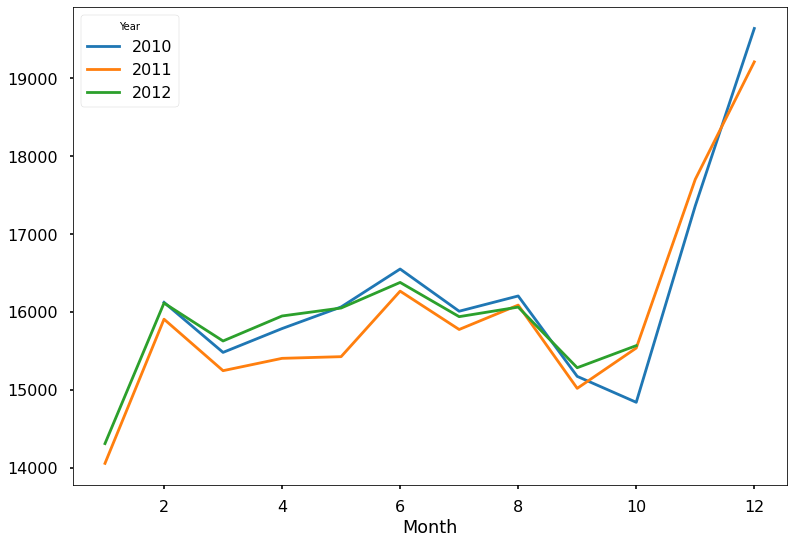

In [59]:
monthly_sales=pd.pivot_table(df,values='Weekly_Sales',columns='Year',index='Month')
monthly_sales.plot()

Seems like 2010 had the best sales followed by 2011 but 2012 has no sales data for 11th and 12 th Month

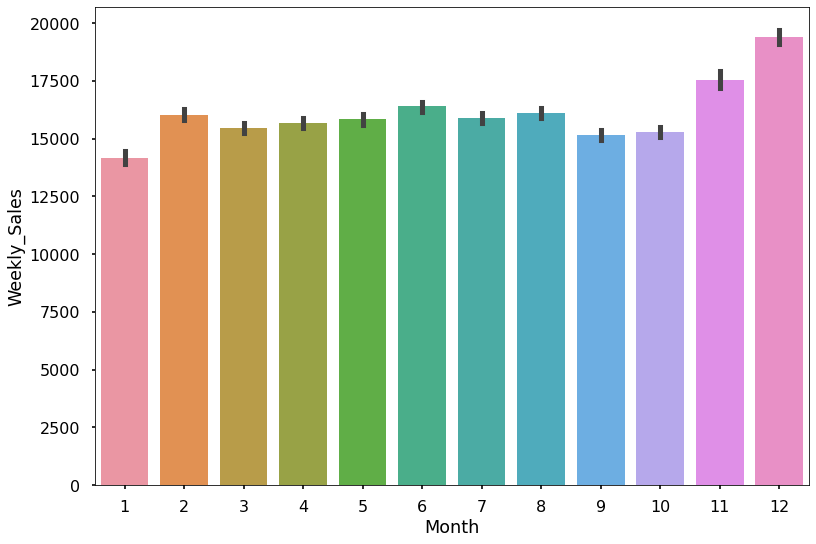

In [60]:
fig=sns.barplot(x='Month',y='Weekly_Sales',data=df)

From the graph above it is clear that the best sales are during the november and december month due to christmas and thanksgiving holidays

In [61]:
df.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

Week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='Week'>

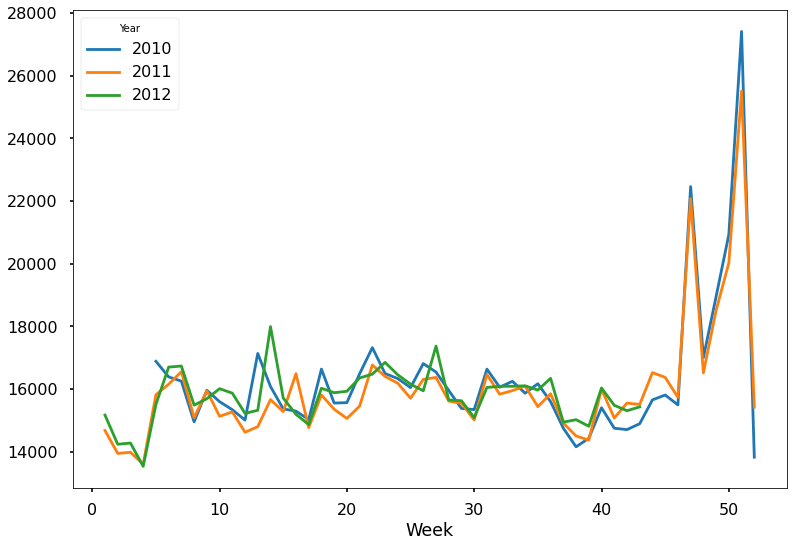

In [62]:
weekly_sales=pd.pivot_table(df,values='Weekly_Sales',columns='Year',index='Week')
weekly_sales.plot()

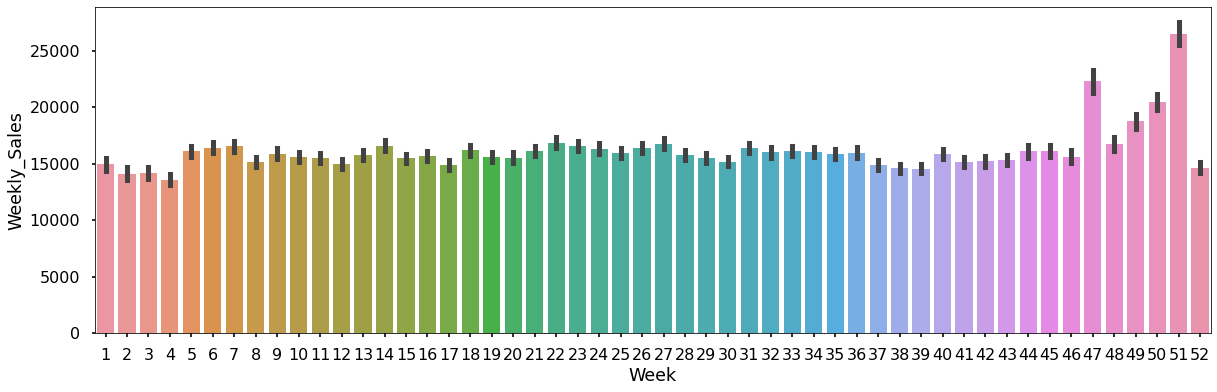

In [63]:
plt.figure(figsize=(20,6))
fig=sns.barplot(x='Week',y='Weekly_Sales',data=df)

It is seen that the 47th week and 51st week are during great due to thanksgiving and christmas holidays

<AxesSubplot:xlabel='Fuel_Price'>

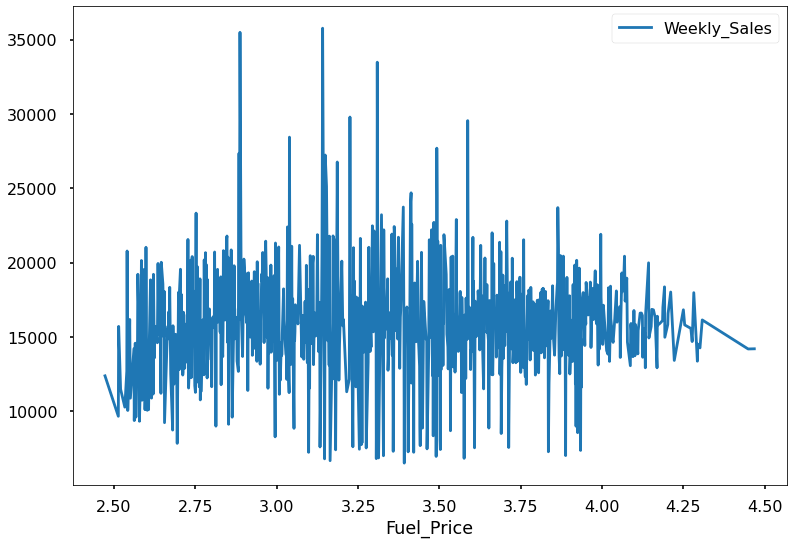

In [64]:
fuel_price=pd.pivot_table(df,values='Weekly_Sales',index='Fuel_Price')
fuel_price.plot()

<AxesSubplot:xlabel='CPI'>

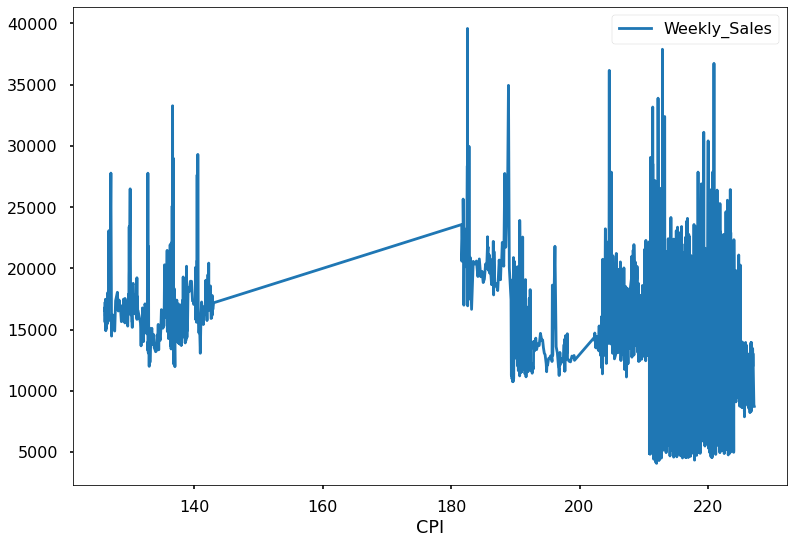

In [65]:
CPI=pd.pivot_table(df,values='Weekly_Sales',index='CPI')
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

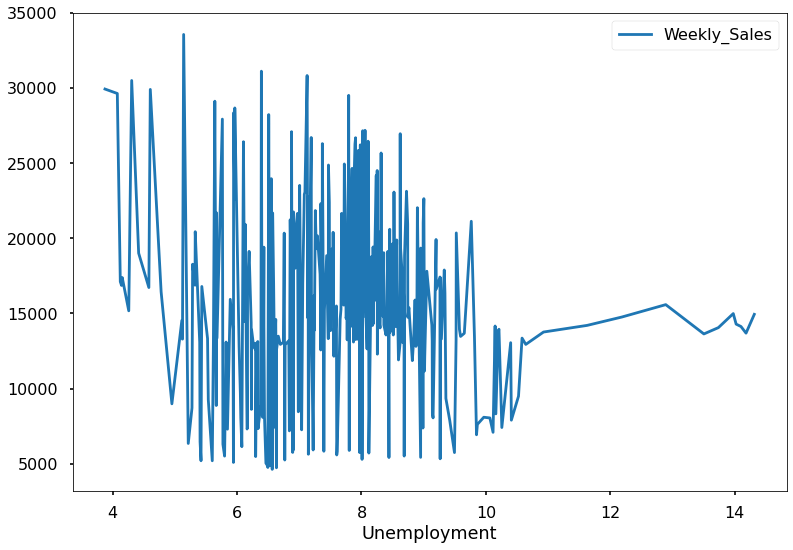

In [66]:
unemployment=pd.pivot_table(df,values='Weekly_Sales',index='Unemployment')
unemployment.plot()

there are no significant pattern in these graphs and also values are missing for CPI at 140-180

In [67]:
df.to_csv('clean_data.csv')

In [68]:
pd.options.display.max_columns=100
df=pd.read_csv('./clean_data.csv')

In [69]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,Week,Month,Year
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [70]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [71]:
df['Date']=pd.to_datetime(df['Date'])

In [72]:
df_encoded=df.copy()

In [73]:
type_group={"A":1,"B":2,"C":3}
df_encoded["Type"]=df_encoded["Type"].replace(type_group)

In [74]:
df_encoded["Super_Bowl"]=df_encoded["Super_Bowl"].astype(bool).astype(int)

In [75]:
df_encoded["Thanksgiving"]=df_encoded["Thanksgiving"].astype(bool).astype(int)

In [76]:
df_encoded["Labor_Day"]=df_encoded["Labor_Day"].astype(bool).astype(int)

In [77]:
df_encoded["Christmas"]=df_encoded["Christmas"].astype(bool).astype(int)

In [78]:
df_encoded["IsHoliday"]=df_encoded["IsHoliday"].astype(bool).astype(int)

In [79]:
df_new=df_encoded.copy()

In [80]:
drop_col=['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col,axis=1,inplace=True)

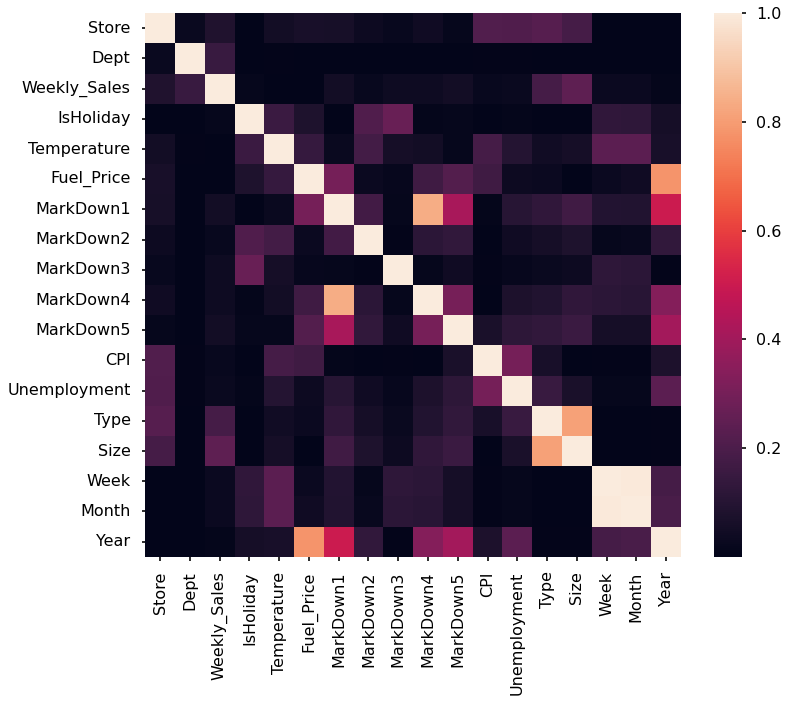

In [81]:
plt.figure(figsize=(12,10))
sns.heatmap(df_new.corr().abs())
plt.show()

Now we remove cols that have no correlation to weekly sales

In [82]:
drop_col=['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col,inplace=True,axis=1)

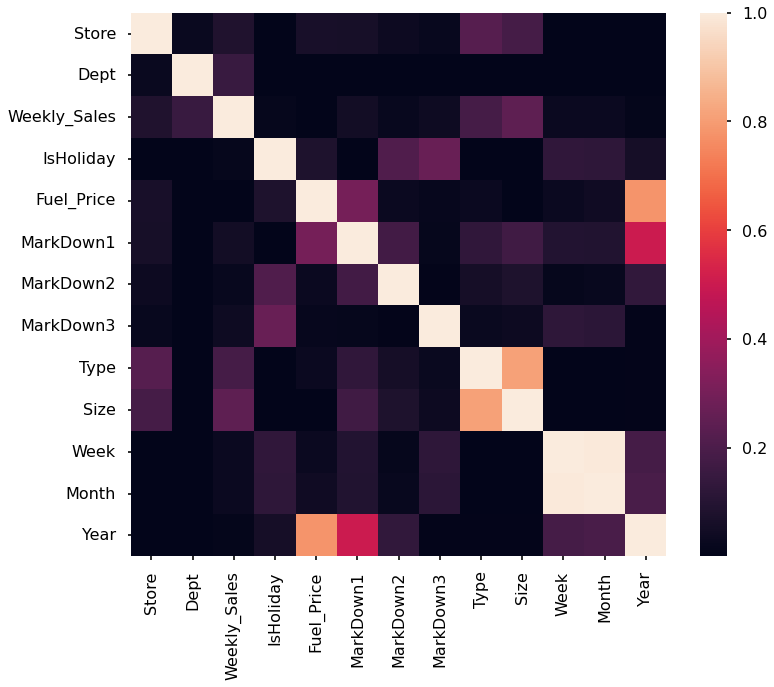

In [83]:
plt.figure(figsize=(12,10))
sns.heatmap(df_new.corr().abs())
plt.show()


Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [84]:
df_new=df_new.sort_values(by="Date",ascending=True)

In [85]:
train_data=df_new[:int(0.7*(len(df_new)))]
test_data=df_new[int(0.7*(len(df_new))):]
target='Weekly_Sales'
used_cols=[c for c in df_new.columns.to_list()if c not in [target]]
x_train=train_data[used_cols]
x_test=test_data[used_cols]
y_train=train_data[target]
y_test=test_data[target]

In [86]:
X=df_new[used_cols]

In [87]:
x_train=x_train.drop(['Date'],axis=1)
x_test=x_test.drop(['Date'],axis=1)

In [88]:
def wmae_test(test,pred):#calculating the wieghted error
    weights=x_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error=np.sum(weights * np.abs(test-pred),axis=0)/np.sum(weights)
    return error

In [89]:
rf=RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1,max_depth=35,max_features='sqrt',min_samples_split=10)

In [90]:
from sklearn.preprocessing import RobustScaler;
scaler=RobustScaler()
pipe=make_pipeline(scaler,rf)
pipe.fit(x_train,y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=35, max_features='sqrt',
                                       min_samples_split=10, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [91]:
pipe.score(x_test,y_test)

0.8397821496023179

In [92]:
pipe.score(x_train,y_train)

0.9012112880325913

In [93]:
y_pred=pipe.predict(x_test)
wmae_test(y_test,y_pred)

5850.444413125214

So weighted error is around 5.9k

Now lets see the feature importance

In [94]:
X=X.drop(['Date'],axis=1)

Feature ranking:
1. feature 1 (0.732822)
2. feature 8 (0.110390)
3. feature 0 (0.054027)
4. feature 7 (0.038210)
5. feature 9 (0.021277)
6. feature 3 (0.018402)
7. feature 10 (0.009446)
8. feature 6 (0.005523)
9. feature 4 (0.003413)
10. feature 5 (0.002776)
11. feature 2 (0.002246)
12. feature 11 (0.001467)


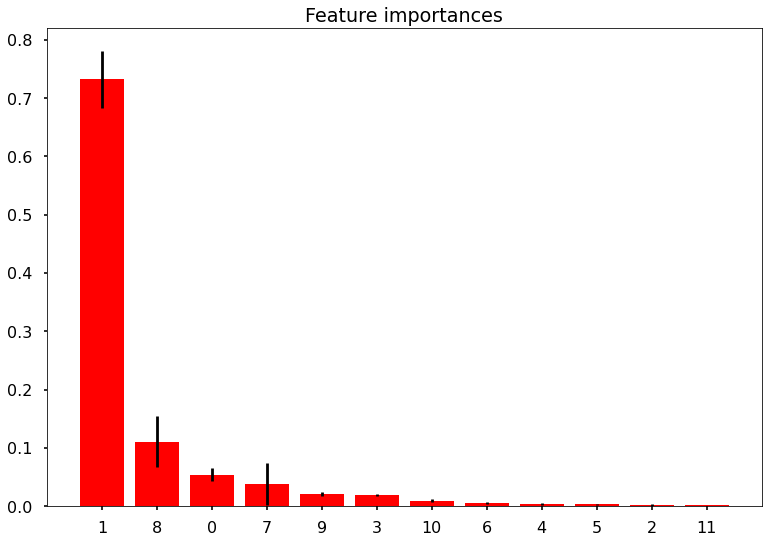

In [95]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [96]:
x1_train=x_train.drop(['Month'],axis=1)
x1_test=x_test.drop(['Month'],axis=1)

Now we try to model without the month

In [97]:
rf=RandomForestRegressor(n_estimators=50,n_jobs=-1,max_depth=35,random_state=42,max_features='sqrt',min_samples_split=10)
scaler=RobustScaler()
pipe=make_pipeline(scaler,rf)
pipe.fit(x1_train,y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=35, max_features='sqrt',
                                       min_samples_split=10, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [98]:
pipe.score(x1_test,y_test)

0.8591207777395355

In [99]:
pipe.score(x1_train,y_train)

0.911739880231018

In [100]:
y_pred_test=pipe.predict(x1_test)
y_pred=pipe.predict(x1_train)

In [101]:
wmae_test(y_test,y_pred_test)

5494.419090545123

We achieved better results than the previous base pipeline.Now lets try modelling with the whole data.

In [102]:
train_data_enc=df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc=df_encoded[int(0.7*len(df_encoded)):]
target='Weekly_Sales'
used_cols1=[c for c in df_encoded.columns.to_list() if c not in [target]]
x_train_enc=train_data_enc[used_cols1]
x_test_enc=test_data_enc[used_cols1]
y_train_enc=train_data_enc[target]
y_test_enc=test_data_enc[target]

In [103]:
X_enc=df_encoded[used_cols1]
X_enc.drop(['Date'],axis=1,inplace=True)

c:\Anaconda\envs\tensorflow_env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [104]:
x_train_enc.drop(['Date'],axis=1,inplace=True)
x_test_enc.drop(['Date'],axis=1,inplace=True)

In [105]:
rf=RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1,max_depth=35,
                         max_features='sqrt',min_samples_split=10)
scaler=RobustScaler()
pipe=make_pipeline(scaler,rf)
pipe.fit(x_train_enc,y_train_enc)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=35, max_features='sqrt',
                                       min_samples_split=10, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [106]:
pipe.score(x_test_enc,y_test_enc)

0.6255968369616652

In [107]:
pipe.score(x_train_enc,y_train_enc)

0.8204877126012291

In [108]:
y_pred_enc=pipe.predict(x_train_enc)
y_pred_test_enc=pipe.predict(x_test_enc)

In [109]:
wmae_test(y_test_enc,y_pred_test_enc)

2450.1012493925496

we got better results for the whole data, meaning data is learning from columns i have dropped before!

Feature ranking:
1. feature 1 (0.743136)
2. feature 13 (0.075801)
3. feature 12 (0.043810)
4. feature 0 (0.031172)
5. feature 10 (0.028007)
6. feature 11 (0.017039)
7. feature 18 (0.012315)
8. feature 3 (0.011079)
9. feature 4 (0.009879)
10. feature 19 (0.005534)
11. feature 7 (0.004481)
12. feature 9 (0.003979)
13. feature 5 (0.003461)
14. feature 8 (0.003315)
15. feature 6 (0.002381)
16. feature 16 (0.001363)
17. feature 20 (0.001200)
18. feature 2 (0.000879)
19. feature 17 (0.000597)
20. feature 14 (0.000290)
21. feature 15 (0.000283)


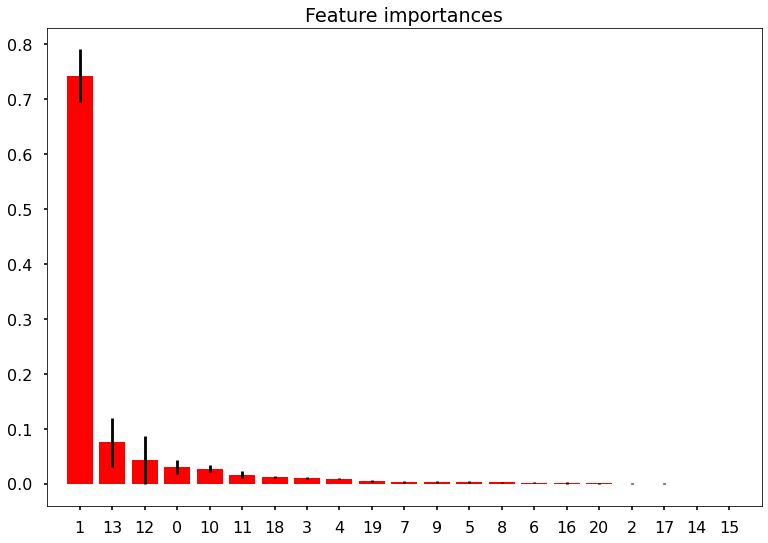

In [112]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()